# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis and Discussion](#analysis)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The COVID pandemic has raged the whole world from its outbreak in January 2020 until today. Due to its nature of transmission and its deadly symptoms, data has been heavily utilized to trace contacts and confirmed cases of people that had contracted the virus in order to reduce its transmission.


From the previous activities, we have utilized Foursquare venue data to get common venues from neighborhoods and cluster these neighborhoods according to their similarity of frequency of specific venues. For this project, we want to look at how common venues in neighborhoods may have affected COVID cases in these neighborhoods through clustering and correlation of population and confirmed covid cases. 

I have taken information in datasets found in the capital region of the Philippines - the National Capital Region or Metro Manila as locals call the region. As a Filipino, I may be able to insert context into the data and further expound correlations in the data analysis.

The results should be able to inform governing bodies in implementing informed quarantine measures and contact tracing to more vulnerable regions.

## Data <a name="data"></a>

To start, neighborhoods in the Philippines are called Barangays and comprise a smaller unit inside a local government unit (LGU) like a city. We'll be grabbing data on the list of barangays in Metro Manila, the population of each barangay (when data is present) and the current confirmed COVID cases as posted by each LGU in Facebook. We'll also be using data on venues closest to these barangays.

1. List of barangays in Metro Manila - https://en.wikipedia.org/wiki/List_of_barangays_of_Metro_Manila

2. List of confirmed COVID cases found in:
	* Public Information Office of the government unit in charge of City (via Facebook)
	* Facebook pages of the current mayor of the government unit
    
    
3. Venues near each barangay via Foursquare API

We scrape the data off the Wikipedia page via pandas. I have personally compiled all of the data on the numbers of covid cases in each barangay. The data is stored in an excel file via Google Drive.

In [31]:
import pandas as pd
#Webscrape wikipedia page via pandas
manila_dummy = pd.read_html('https://en.wikipedia.org/wiki/List_of_barangays_of_Metro_Manila')
covid = pd.read_excel('https://drive.google.com/uc?id=1Nsw3K6e1GntljYfJ7zaU2hWolJUBoBvw&export=download',
              sheet_name='A_edit_') 
manila = pd.concat([manila_dummy[x] for x in range(1,25)], axis=0).reset_index(drop=True)
manila

,Name,Population(2015)[2],ZIP Code[7],City/Municipality
0,Acacia,5127.0,1474,Malabon
1,Addition Hills,99058.0,1552,Mandaluyong
2,Addition Hills,3739.0,NaN,San Juan
3,Aguho,NaN,1620,Pateros
4,Alabang,63793.0,1777,Muntinlupa
...,...,...,...,...
514,West Rembo,29899.0,1215,Makati
515,West Triangle,4199.0,1104,Quezon City
516,Western Bicutan,91158.0,1630,Taguig
517,White Plains,4734.0,1110,Quezon City


We now render the map backdrop where the data will be drawn using Folium. We will also find the respective coordinates of the barangays listed in the Wikipedia page. All barangays that did not return coordinates will be dropped in future analysis. The same method applied in Week 2 of the capstone will be applied here.

In [32]:
from geopy.geocoders import Nominatim
address= 'National Capital Region, Philippines'

geolocator = Nominatim(user_agent="capstone")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of National Capital Region, Philippines are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of National Capital Region, Philippines are 14.5736108, 121.0329706.


In [33]:
latitude_x = [None] * 519
longitude_x = [None] * 519
for index,x in manila.iterrows():
    location1 = geolocator.geocode('{}, {}'.format(x[0],x[3]))
    if location1 is None:
        continue
    latitude_x[index]=location1.latitude
    longitude_x[index]=location1.longitude

In [34]:
final_df = pd.DataFrame({'Neighborhood':manila['Name'],'City/Municipality':manila['City/Municipality'],'Latitude':latitude_x,'Longitude':longitude_x})
final_df.dropna(inplace=True)

In [127]:
import folium 
# create map of Toronto using latitude and longitude values
map_manila= folium.Map(location=[latitude, longitude], zoom_start=10)
final_df1=final_df.dropna()
for index, x in final_df1.iterrows():
    label = '{}, {}'.format(x[1],x[2])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [x[2], x[3]],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manila) 
  
map_manila


Now that we have the necessary information to scrape venues through the Foursquare API, we now proceed to retrieve nearby venues for each barangay. The same methodology will be applied from the Week 2 of the capstone.

In [36]:
CLIENT_ID = 'IUAZRPBJO2WU52PVY5KNCKTU4FG23TLDGESFU45FH1B2HX0S' # your Foursquare ID
CLIENT_SECRET = 'KDYE21MN0U03DJGF3JHJHSD5QWVH3ZGSRTUB2045NDWWOAD5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [37]:
radius = 500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
import requests
manila_venues = getNearbyVenues(names=final_df['Neighborhood'],
                                   latitudes=final_df['Latitude'],
                                   longitudes=final_df['Longitude']
                                  )

Acacia
Addition Hills
Addition Hills
Aguho
Alabang
Alicia
Almanza Uno
Almanza Dos
Amihan
Amparo
Apolonio Samson
Arkong Bato
Aurora
Ayala Alabang (New Alabang)
Baclaran
Baesa
Baesa
Bagbag
Bagbaguin
Bagong Barrio
Bagong Ilog
Bagong Katipunan
Bagong Lipunan ng Crame
Bagong Pag-asa
Bagong Silang
Bagong Silang
Bagong Silangan
Bagumbayan
Bagumbayan
Bagumbayan North
Bagumbayan South
Bagumbong
Bagumbuhay
Bahay Toro
Balangkas
Balingasa
Balintawak
Balic-Balic
Balong Bato
Balong-bato
Balut
Bambang
Bambang
Bangkal
Bangkulasi
Barangka
Barangka Drive
Barangka Ibaba
Barangka Ilaya
Barangka Itaas
Baritan
Barrio San Jose
Batasan Hills
Batis
Bay City
Bayanan
Bayanihan
Bayan-bayanan
Bel-Air
BF Homes Caloocan
BF Homes
BF International Village-CAA
Biglang-Awa
Bignay
Binondo
Bisig
Blue Ridge A
Blue Ridge B
Botocan
Buayang Bato
Buli
Bungad
Burol
Buting
Cabrera
Calumpang
Calzada
Camarin
Camarin-Central
Camarin-Cielito
Camp Aguinaldo
Caniogan
Canumay East
Canumay West
Capri
Carmona
Cartimar
Catmon
Caybiga
Cemb

KeyError: 'groups'

In [39]:
print(manila_venues.shape)
manila_venues.head()

(8743, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acacia,14.668471,120.96998,Save More,14.670069,120.970051,Grocery Store
1,Acacia,14.668471,120.96998,Jollibee,14.668310,120.965801,Fast Food Restaurant
2,Acacia,14.668471,120.96998,Dunkin',14.668701,120.966594,Donut Shop
3,Acacia,14.668471,120.96998,Max's Restaurant,14.667699,120.965948,Fried Chicken Joint
4,Acacia,14.668471,120.96998,Chowking,14.666208,120.966650,Chinese Restaurant


Now that we have the backdrop and the necessary data for analysis, we now discuss the methodology in executing the analysis and draw results.

## Methodology <a name="methodology"></a>

From the previous processing, we have gathered the required data: **location of every venue near barangays** within Metro Manila and the **Number of COVID cases** for each barangay. The wikipedia page also provides values on population of each barangay. This will also be used for analysis. However, it is important to note that the data was gathered in 2015 so the **actual percentage ratios of confirmed cases to yet-to-be affected persons will be far** from the results here. For the sake of discussion, we assume that the rate of difference in populations between barangays should be the same for today. The next step would be to process the data to get the frequency of venues in a barangay via one-hot encoding.

After one-hot encoding, we will be utilizing K-means clustering to find commonalities between common venues in barangays and give context towards the covid cases in each barangay. After clustering and encoding, we will be plotting the clusters (via color) and COVID cases/Population (via size) of each barangay and try to correlate the clustering of barangays (based on common venues) and the number of covid cases in that barangay.

After the analysis, we will conclude on how the common venues may have affected the rate of infection in each barangay based on the potential movement of people through these venues.

## Analysis and Discussion<a name="analysis"></a>

We now proceed to one hot encoding and listing of top venues. The methodology will be the same as Week 2 of the capstone

In [40]:
# one hot encoding
manila_onehot = pd.get_dummies(manila_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manila_onehot['_Neighborhood'] = manila_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [manila_onehot.columns[-1]] + list(manila_onehot.columns[:-1])
manila_onehot = manila_onehot[fixed_columns]

manila_onehot.head()

,_Neighborhood,ATM,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Acacia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acacia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acacia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Acacia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acacia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
manila_grouped = manila_onehot.groupby('_Neighborhood').mean().reset_index()
manila_grouped

,_Neighborhood,ATM,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Acacia,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0
1,Addition Hills,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.03125,0.0,0.0
2,Aguho,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0
3,Alabang,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.011111,...,0.0,0.0,0.0,0.011111,0.0,0.011111,0.0,0.00000,0.0,0.0
4,Alicia,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,West Rembo,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0
451,West Triangle,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0
452,Western Bicutan,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0
453,White Plains,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0


In [42]:
num_top_venues = 5

for hood in manila_grouped['_Neighborhood']:
    print("----"+hood+"----")
    temp = manila_grouped[manila_grouped['_Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acacia----
                venue  freq
0       Shopping Mall  0.22
1       Grocery Store  0.22
2        Burger Joint  0.11
3  Chinese Restaurant  0.11
4          Donut Shop  0.11


----Addition Hills----
                 venue  freq
0  Japanese Restaurant  0.09
1                  Bar  0.09
2   Chinese Restaurant  0.09
3      Bubble Tea Shop  0.06
4               Bakery  0.06


----Aguho----
                  venue  freq
0  Fast Food Restaurant  0.57
1      Asian Restaurant  0.14
2    Chinese Restaurant  0.14
3                Resort  0.14
4                   ATM  0.00


----Alabang----
                  venue  freq
0           Coffee Shop  0.09
1  Fast Food Restaurant  0.07
2                Bakery  0.06
3           Pizza Place  0.04
4    Chinese Restaurant  0.03


----Alicia----
             venue  freq
0    Grocery Store  0.33
1      Bridal Shop  0.33
2              Spa  0.33
3              ATM  0.00
4  Organic Grocery  0.00


----Almanza Dos----
                venue  freq
0  Seaf

4              Pharmacy  0.04


----Bangkulasi----
                  venue  freq
0   Filipino Restaurant  0.43
1              Pharmacy  0.14
2            Playground  0.14
3  Fast Food Restaurant  0.14
4             Gastropub  0.14


----Barangka----
                  venue  freq
0         Shopping Mall  0.13
1     Convenience Store  0.13
2    Chinese Restaurant  0.07
3           Pizza Place  0.07
4  Fast Food Restaurant  0.07


----Barangka Drive----
                  venue  freq
0                   Spa  0.12
1     Convenience Store  0.12
2                   Bar  0.06
3  Fast Food Restaurant  0.06
4           Bridal Shop  0.06


----Barangka Ibaba----
                  venue  freq
0                   Bar   0.2
1            Food Truck   0.2
2            Taco Place   0.2
3      Basketball Court   0.2
4  Fast Food Restaurant   0.2


----Barangka Ilaya----
                  venue  freq
0     Convenience Store  0.11
1           Coffee Shop  0.07
2   Filipino Restaurant  0.06
3  Fast Food Re

                  venue  freq
0                  Park  0.33
1              Pharmacy  0.17
2      Basketball Court  0.17
3  Fast Food Restaurant  0.17
4     Convenience Store  0.17


----Central----
                 venue  freq
0          Coffee Shop  0.12
1  Filipino Restaurant  0.12
2                Diner  0.08
3          Karaoke Bar  0.08
4    Korean Restaurant  0.08


----Central Signal Village----
                     venue  freq
0         Asian Restaurant  0.22
1        Convenience Store  0.11
2       Chinese Restaurant  0.11
3  Comfort Food Restaurant  0.11
4             Food Service  0.11


----Claro----
                  venue  freq
0     Convenience Store  0.14
1  Fast Food Restaurant  0.11
2                   Bar  0.07
3             BBQ Joint  0.07
4           Coffee Shop  0.07


----Coloong----
                           venue  freq
0                           Lake   1.0
1                            ATM   0.0
2                      Pawn Shop   0.0
3                          

                 venue  freq
0          Coffee Shop  0.08
1   Italian Restaurant  0.06
2       Ice Cream Shop  0.04
3  Sporting Goods Shop  0.03
4  Japanese Restaurant  0.03


----Fortune----
                  venue  freq
0            Smoke Shop  0.25
1  Fast Food Restaurant  0.25
2           Flea Market  0.25
3      Asian Restaurant  0.25
4                   ATM  0.00


----Francis Burton Harrison----
                  venue  freq
0                 Hotel  0.19
1  Fast Food Restaurant  0.12
2                  Café  0.06
3                 Diner  0.06
4  Gym / Fitness Center  0.06


----Gagalangin----
                  venue  freq
0  Fast Food Restaurant  0.20
1       Bubble Tea Shop  0.13
2                Bakery  0.07
3     Food & Drink Shop  0.07
4         Shopping Mall  0.07


----General T. de Leon----
                  venue  freq
0     Convenience Store  0.29
1  Fast Food Restaurant  0.29
2                Casino  0.14
3            Soup Place  0.14
4  Gym / Fitness Center  0.14


--

4          Other Nightlife  0.00


----La Paz----
                 venue  freq
0                Hotel  0.10
1  Filipino Restaurant  0.10
2    Convenience Store  0.07
3          Gas Station  0.03
4      Bubble Tea Shop  0.03


----Laging Handa----
                 venue  freq
0  Filipino Restaurant  0.06
1            BBQ Joint  0.06
2               Bakery  0.05
3   Seafood Restaurant  0.05
4                  Spa  0.04


----Lawang Bato----
                           venue  freq
0              Convenience Store   1.0
1                Organic Grocery   0.0
2                           Park   0.0
3  Paper / Office Supplies Store   0.0
4              Paella Restaurant   0.0


----Layug----
                  venue  freq
0  Fast Food Restaurant  0.14
1   Japanese Restaurant  0.10
2                 Hotel  0.10
3     Convenience Store  0.07
4               Theater  0.05


----Leveriza----
                  venue  freq
0  Fast Food Restaurant  0.44
1     Convenience Store  0.19
2    Chinese Resta

4               Park  0.00


----Maysilo----
               venue  freq
0  Convenience Store  0.25
1               Pool  0.25
2         Hotel Pool  0.25
3     Discount Store  0.25
4    Organic Grocery  0.00


----Maytunas----
                           venue  freq
0            Japanese Restaurant  0.12
1                           Café  0.09
2  Vegetarian / Vegan Restaurant  0.06
3                            Spa  0.06
4            Filipino Restaurant  0.06


----Merville----
                           venue  freq
0                           Park  0.50
1              Convenience Store  0.25
2                           Café  0.25
3                     Nail Salon  0.00
4  Paper / Office Supplies Store  0.00


----Milagrosa----
                 venue  freq
0         Dessert Shop  0.10
1            BBQ Joint  0.08
2  Filipino Restaurant  0.08
3                  Bar  0.08
4                 Café  0.05


----Monumento----
                  venue  freq
0  Fast Food Restaurant  0.30
1    Chinese 

                           venue  freq
0              Convenience Store  0.50
1           Fast Food Restaurant  0.25
2                      Gift Shop  0.25
3                     Nail Salon  0.00
4  Paper / Office Supplies Store  0.00


----Pandacan----
           venue  freq
0  Grocery Store  0.25
1     Nail Salon  0.12
2      Bookstore  0.12
3    Supermarket  0.12
4          Plaza  0.12


----Pangarap Village----
                    venue  freq
0      Athletics & Sports   0.2
1               Bookstore   0.2
2  Furniture / Home Store   0.2
3              Restaurant   0.2
4                     Gym   0.2


----Panghulo----
                           venue  freq
0                  Grocery Store  0.50
1                    Snack Place  0.25
2                          Diner  0.25
3                           Park  0.00
4  Paper / Office Supplies Store  0.00


----Pansol----
              venue  freq
0  Asian Restaurant  0.17
1         Bookstore  0.08
2            Bakery  0.08
3              P

4                   ATM  0.00


----Rosario----
                  venue  freq
0         Grocery Store  0.33
1     Convenience Store  0.11
2     Korean Restaurant  0.11
3      Tapas Restaurant  0.11
4  Fast Food Restaurant  0.11


----Roxas----
                  venue  freq
0                  Café  0.27
1    Athletics & Sports  0.09
2      Basketball Court  0.09
3       Badminton Court  0.09
4  Fast Food Restaurant  0.09


----Sacred Heart----
                 venue  freq
0  Filipino Restaurant  0.13
1                  Bar  0.11
2          Coffee Shop  0.08
3                  Spa  0.07
4      Bubble Tea Shop  0.05


----Sagad----
                  venue  freq
0     Convenience Store  0.26
1         Grocery Store  0.09
2                Bakery  0.09
3  Fast Food Restaurant  0.09
4              Pharmacy  0.04


----Salapan----
                venue  freq
0  Chinese Restaurant  0.22
1         Gas Station  0.11
2        Intersection  0.11
3         Music Venue  0.11
4        Dance Studio  0.

                  venue  freq
0  Fast Food Restaurant  0.25
1              Pharmacy  0.12
2           Supermarket  0.12
3            Donut Shop  0.12
4           Pizza Place  0.12


----Santo Tomas----
                  venue  freq
0     Convenience Store  0.20
1           Pizza Place  0.12
2    Chinese Restaurant  0.08
3  Fast Food Restaurant  0.08
4                Bakery  0.08


----Santol----
                venue  freq
0  Chinese Restaurant  0.29
1   Convenience Store  0.14
2         Event Space  0.14
3         Pizza Place  0.14
4               Hotel  0.14


----Santolan----
                 venue  freq
0          Coffee Shop  0.09
1    Electronics Store  0.06
2  Fried Chicken Joint  0.06
3  Japanese Restaurant  0.06
4      Bubble Tea Shop  0.06


----Sauyo----
                  venue  freq
0   American Restaurant  0.33
1  Fast Food Restaurant  0.33
2           Flower Shop  0.33
3                   ATM  0.00
4       Organic Grocery  0.00


----Siena----
                  venue  fre

              venue  freq
0       Rugby Pitch  0.25
1  Basketball Court  0.25
2              Café  0.25
3  Asian Restaurant  0.25
4   Other Nightlife  0.00


----Tramo----
                  venue  freq
0  Fast Food Restaurant  0.19
1     Convenience Store  0.19
2    Chinese Restaurant  0.10
3           Bus Station  0.10
4    Seafood Restaurant  0.05


----Tripa De Gallina----
                  venue  freq
0  Fast Food Restaurant  0.24
1     Convenience Store  0.12
2                Bakery  0.06
3                 Hotel  0.06
4            Food Court  0.03


----Tugatog----
                  venue  freq
0     Convenience Store   0.1
1          Burger Joint   0.1
2         Grocery Store   0.1
3                Market   0.1
4  Fast Food Restaurant   0.1


----Tuktukan----
                  venue  freq
0  Fast Food Restaurant  0.23
1           Supermarket  0.09
2         Shopping Mall  0.09
3             Bookstore  0.05
4      Basketball Court  0.05


----Tumana----
             venue  freq
0 

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['_Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['_Neighborhood'] = manila_grouped['_Neighborhood']

for ind in np.arange(manila_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manila_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,_Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acacia,Grocery Store,Shopping Mall,Donut Shop,Chinese Restaurant,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Flea Market,Empanada Restaurant,Dumpling Restaurant
1,Addition Hills,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café
2,Aguho,Fast Food Restaurant,Chinese Restaurant,Resort,Asian Restaurant,Zoo Exhibit,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
3,Alabang,Coffee Shop,Fast Food Restaurant,Bakery,Pizza Place,Hotel,Bubble Tea Shop,Restaurant,Chinese Restaurant,Clothing Store,Convenience Store
4,Alicia,Grocery Store,Bridal Shop,Spa,Fast Food Restaurant,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant


We now proceed to cluster the barangays from their common venues using K-means clustering

In [54]:
from sklearn.cluster import KMeans
kclusters = 5

manila_grouped_clustering = manila_grouped.drop('_Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manila_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 4])

In [66]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manila_merged = final_df


manila1 = manila[['Name','Population(2015)[2]']].dropna()
manila1.rename(columns={'Population(2015)[2]':'Population'},inplace=True)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manila_merged = manila_merged.join(neighborhoods_venues_sorted.set_index('_Neighborhood'), on='Neighborhood')
manila_merged = manila_merged.merge(manila1.set_index('Name'), left_on='Neighborhood',right_on='Name',how='left')

manila_merged.head() # check the last columns!

,Neighborhood,City/Municipality,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
0,Acacia,Malabon,14.668471,120.969980,0.0,Grocery Store,Shopping Mall,Donut Shop,Chinese Restaurant,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Flea Market,Empanada Restaurant,Dumpling Restaurant,5127.0
1,Addition Hills,Mandaluyong,14.584640,121.036301,0.0,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café,99058.0
2,Addition Hills,Mandaluyong,14.584640,121.036301,0.0,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café,3739.0
3,Addition Hills,San Juan,14.594252,121.040723,0.0,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café,99058.0
4,Addition Hills,San Juan,14.594252,121.040723,0.0,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café,3739.0


Now that we have the clusters for the barangays. We now proceed to plot these data using Folium.

In [126]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


manila_merged1 = manila_merged.dropna()


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, size in zip(manila_merged1['Latitude'], manila_merged1['Longitude'], manila_merged1['Neighborhood'], manila_merged1['Cluster Labels'].astype(int),manila_merged1['Population']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=size/10000,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

From the plot, we can see three major clusters (Blue, Orange and Red). Red (Cluster 0.0) is the cluster that contained the most barangays. Blue (Cluster 2.0) comes second and Orange (Cluster 4.0) comes third. From the summary of mean values (below), we can see that the blue cluster gets a higher average population. Red cluster receives the second highest mean population and orange cluster receives the third highest mean population.

Further analysis will be described by looking at the common venues for the clusters

In [68]:
manila_merged.loc[manila_merged['Cluster Labels'] == 0, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,City/Municipality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
0,Malabon,Grocery Store,Shopping Mall,Donut Shop,Chinese Restaurant,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Flea Market,Empanada Restaurant,Dumpling Restaurant,5127.0
1,Mandaluyong,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café,99058.0
2,Mandaluyong,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café,3739.0
3,San Juan,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café,99058.0
4,San Juan,Chinese Restaurant,Bar,Japanese Restaurant,Bakery,Bubble Tea Shop,Convenience Store,Vegetarian / Vegan Restaurant,Movie Theater,Fast Food Restaurant,Café,3739.0
...,...,...,...,...,...,...,...,...,...,...,...,...
593,City of Manila,Park,Café,Chinese Restaurant,Snack Place,Burger Joint,Zoo Exhibit,Event Space,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,NaN
595,Taguig,Basketball Court,Pizza Place,Sandwich Place,Diner,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,11177.0
597,San Juan,Movie Theater,Multiplex,Shopping Mall,Coffee Shop,Asian Restaurant,Market,Mediterranean Restaurant,Salad Place,Donut Shop,Doner Restaurant,16773.0
600,Quezon City,Café,Spa,Coffee Shop,Bar,Chinese Restaurant,Dessert Shop,Fast Food Restaurant,Beer Garden,Gym / Fitness Center,Tea Room,4199.0


<AxesSubplot:ylabel='1st Most Common Venue'>

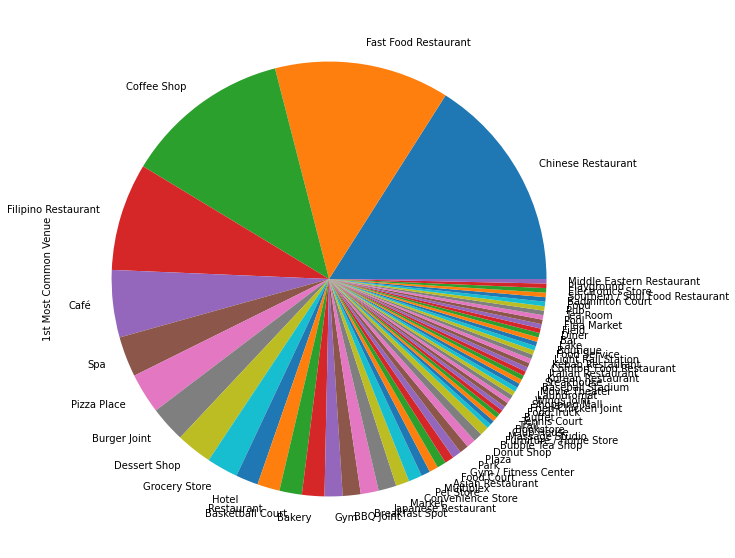

In [117]:
manila_merged.loc[manila_merged['Cluster Labels'] == 0, '1st Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

<AxesSubplot:ylabel='2nd Most Common Venue'>

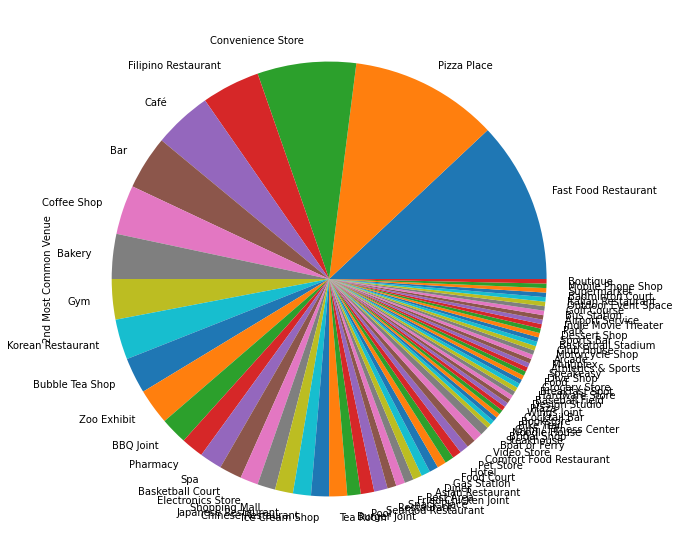

In [118]:
manila_merged.loc[manila_merged['Cluster Labels'] == 0, '2nd Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

<AxesSubplot:ylabel='3rd Most Common Venue'>

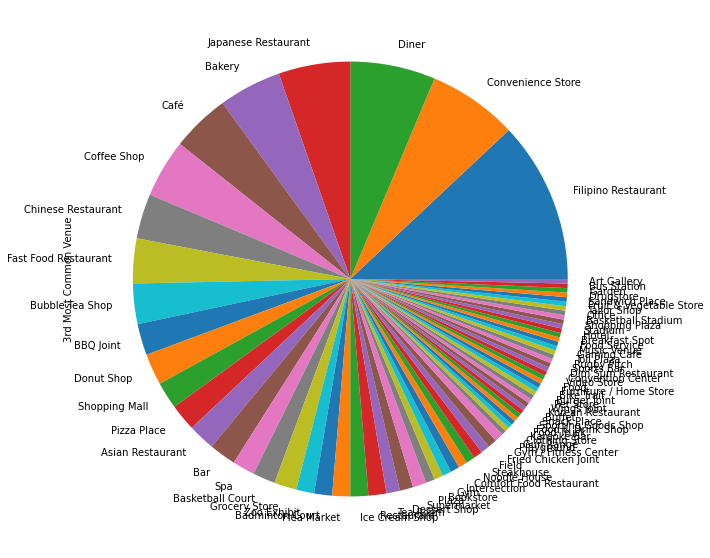

In [119]:
manila_merged.loc[manila_merged['Cluster Labels'] == 0, '3rd Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

In [69]:
manila_merged.loc[manila_merged['Cluster Labels'] == 1, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,City/Municipality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
88,Valenzuela,Pool,Zoo Exhibit,Fast Food Restaurant,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,12462.0
94,Caloocan,Convenience Store,Pool,Zoo Exhibit,Field,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,NaN
106,Caloocan,Pool,Tea Room,Fried Chicken Joint,Coffee Shop,Restaurant,Fast Food Restaurant,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,NaN
118,Malabon,Pool,Resort,Filipino Restaurant,Zoo Exhibit,Farmers Market,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,12124.0
161,Taguig,Water Park,Pool,Basketball Court,Zoo Exhibit,Fast Food Restaurant,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,18652.0
180,Pasay,Bakery,Pool,Fried Chicken Joint,Spa,Fast Food Restaurant,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,NaN
251,Malabon,Convenience Store,Hotel Pool,Pool,Discount Store,Zoo Exhibit,Fast Food Restaurant,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,11262.0
311,Quezon City,Convenience Store,Pool,Basketball Court,Burger Joint,Food & Drink Shop,Food,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,103100.0
340,Valenzuela,Pool,Motorcycle Shop,Resort,Zoo Exhibit,Fast Food Restaurant,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,20930.0
380,Quezon City,Pool,Bakery,Fast Food Restaurant,Field,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,45188.0


In [59]:
manila_merged.loc[manila_merged['Cluster Labels'] == 2, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,City/Municipality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
5,Pateros,Fast Food Restaurant,Chinese Restaurant,Resort,Asian Restaurant,Zoo Exhibit,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,NaN
16,Parañaque,Fast Food Restaurant,Convenience Store,Fried Chicken Joint,Seafood Restaurant,Zoo Exhibit,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,28385.0
17,Caloocan,Fast Food Restaurant,Gym,Pharmacy,Gym / Fitness Center,Automotive Shop,Convenience Store,Flea Market,Fishing Store,Dumpling Restaurant,Food Court,61278.0
18,Quezon City,Fast Food Restaurant,Gym,Pharmacy,Gym / Fitness Center,Automotive Shop,Convenience Store,Flea Market,Fishing Store,Dumpling Restaurant,Food Court,61278.0
21,Caloocan,Fast Food Restaurant,Motel,Convenience Store,Dessert Shop,Steakhouse,Bubble Tea Shop,Bookstore,Buffet,Mobile Phone Shop,Shopping Mall,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
564,Pasay,Fast Food Restaurant,Convenience Store,Hotel,Bakery,Liquor Store,Bus Station,Chinese Restaurant,Shopping Mall,Grocery Store,BBQ Joint,NaN
566,Taguig,Fast Food Restaurant,Supermarket,Shopping Mall,Pizza Place,Restaurant,Convenience Store,Bookstore,Fried Chicken Joint,Cantonese Restaurant,Basketball Court,10730.0
582,Taguig,Fast Food Restaurant,Club House,Automotive Shop,Coffee Shop,Field,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,54186.0
599,Makati,Fast Food Restaurant,Convenience Store,Snack Place,Hostel,Zoo Exhibit,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,29899.0


<AxesSubplot:ylabel='1st Most Common Venue'>

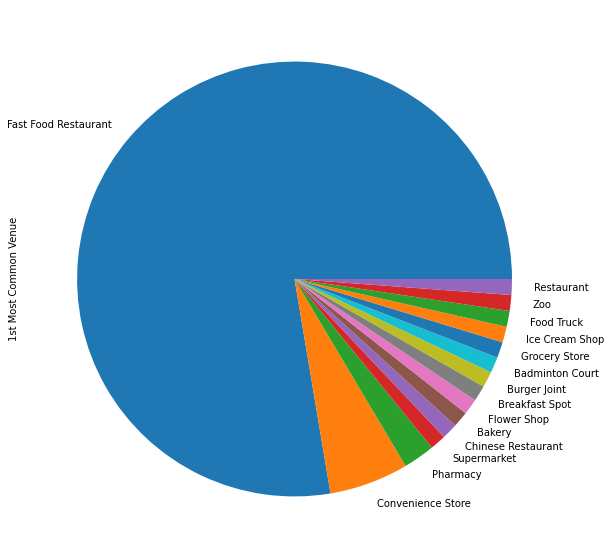

In [120]:
manila_merged.loc[manila_merged['Cluster Labels'] == 2, '1st Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

<AxesSubplot:ylabel='2nd Most Common Venue'>

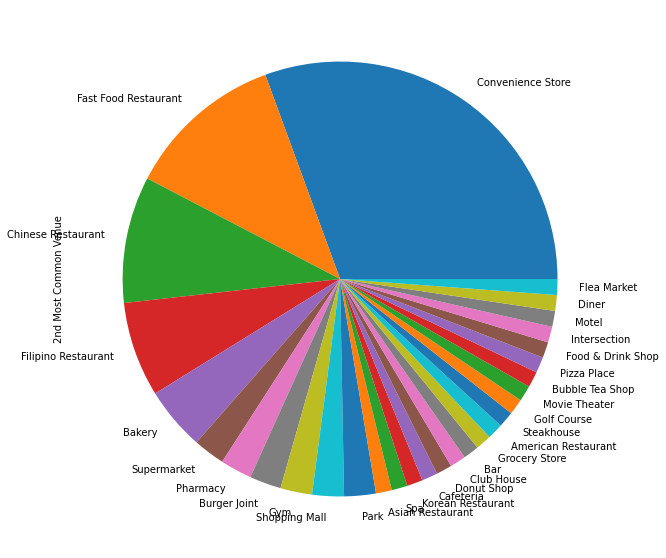

In [121]:
manila_merged.loc[manila_merged['Cluster Labels'] == 2, '2nd Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

<AxesSubplot:ylabel='3rd Most Common Venue'>

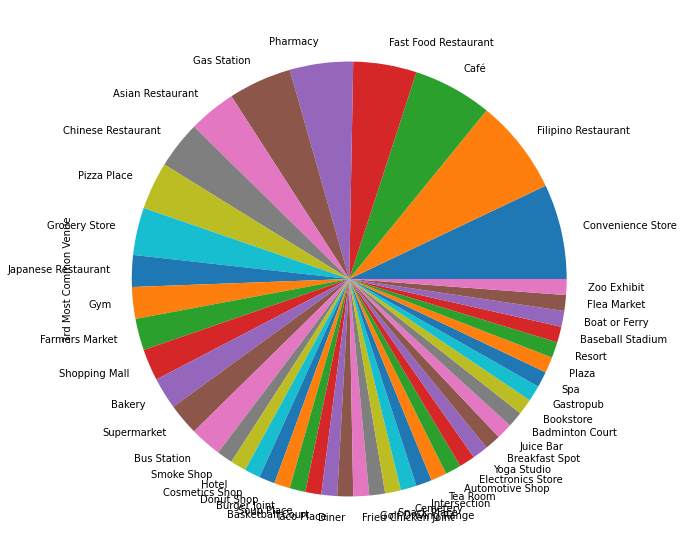

In [122]:
manila_merged.loc[manila_merged['Cluster Labels'] == 2, '3rd Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

In [70]:
manila_merged.loc[manila_merged['Cluster Labels'] == 3, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,City/Municipality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
20,Valenzuela,Convenience Store,Café,Bike Rental / Bike Share,Field,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Farmers Market,13770.0
42,Quezon City,Convenience Store,Market,Zoo Exhibit,Field,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,8228.0
57,Caloocan,Convenience Store,Pizza Place,Bakery,Food Court,Fast Food Restaurant,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,NaN
77,Quezon City,Convenience Store,Intersection,Furniture / Home Store,Deli / Bodega,Health Food Store,Zoo Exhibit,Field,Duty-free Shop,Eastern European Restaurant,Electronics Store,8057.0
80,Pasay,Convenience Store,Pizza Place,Fast Food Restaurant,Zoo Exhibit,Field,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,NaN
85,Caloocan,Convenience Store,Pharmacy,Farmers Market,Field,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,NaN
123,Caloocan,Convenience Store,Fast Food Restaurant,Dim Sum Restaurant,Miscellaneous Shop,Zoo Exhibit,Field,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,NaN
124,Caloocan,Convenience Store,Fast Food Restaurant,Dim Sum Restaurant,Miscellaneous Shop,Zoo Exhibit,Field,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,NaN
194,Parañaque,Convenience Store,Fast Food Restaurant,Dessert Shop,Zoo Exhibit,Field,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,9569.0
197,Valenzuela,Convenience Store,Zoo Exhibit,Field,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Farmers Market,19301.0


In [71]:
manila_merged.loc[manila_merged['Cluster Labels'] == 4, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,City/Municipality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
12,Quezon City,Café,Convenience Store,Pharmacy,Furniture / Home Store,Snack Place,Chinese Restaurant,Hardware Store,Construction & Landscaping,Dance Studio,Costume Shop,38583.0
14,Quezon City,Convenience Store,Filipino Restaurant,Chinese Restaurant,Grocery Store,Shop & Service,Basketball Court,Café,Dessert Shop,Noodle House,Field,5636.0
19,Quezon City,Convenience Store,Fast Food Restaurant,Comfort Food Restaurant,Pharmacy,Salon / Barbershop,Korean Restaurant,Bar,Soup Place,Bakery,Filipino Restaurant,56936.0
22,Pasig,Convenience Store,Restaurant,Warehouse Store,Fast Food Restaurant,Men's Store,Café,Bakery,Veterinarian,Badminton Court,Comfort Food Restaurant,16797.0
23,Pasig,Convenience Store,Pizza Place,Chinese Restaurant,Café,Fast Food Restaurant,Diner,Spa,Donut Shop,Pet Store,Basketball Court,1231.0
...,...,...,...,...,...,...,...,...,...,...,...,...
584,Makati,Convenience Store,Filipino Restaurant,Café,Pizza Place,Diner,Drugstore,Basketball Court,Malay Restaurant,Bar,Brewery,6310.0
591,Pasay,Convenience Store,Japanese Restaurant,Bakery,Café,Restaurant,Donut Shop,Dog Run,Bagel Shop,Gas Station,Event Space,NaN
594,Mandaluyong,Convenience Store,Paper / Office Supplies Store,Auto Garage,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Farmers Market,8965.0
598,Quezon City,Bakery,Fast Food Restaurant,Convenience Store,Electronics Store,Restaurant,Spa,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,4918.0


<AxesSubplot:ylabel='1st Most Common Venue'>

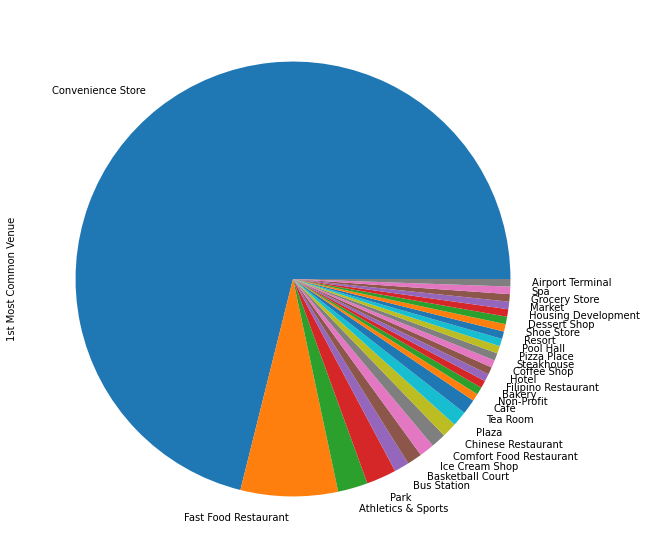

In [123]:
manila_merged.loc[manila_merged['Cluster Labels'] == 4, '1st Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

<AxesSubplot:ylabel='2nd Most Common Venue'>

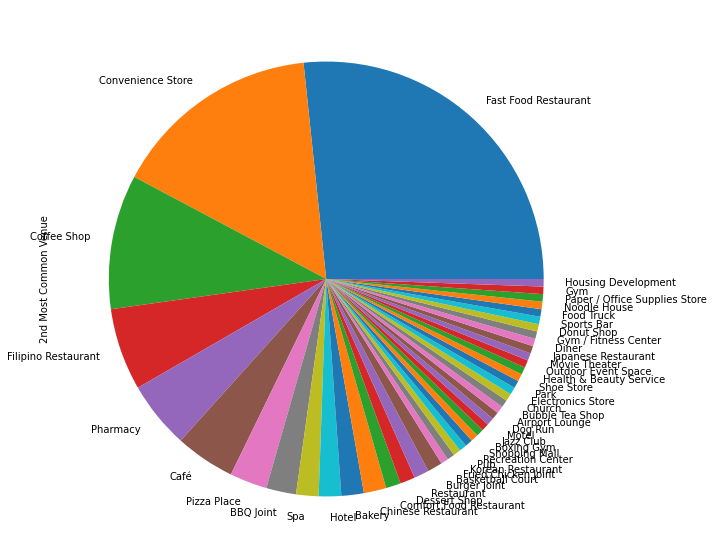

In [124]:
manila_merged.loc[manila_merged['Cluster Labels'] == 4, '2nd Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

<AxesSubplot:ylabel='3rd Most Common Venue'>

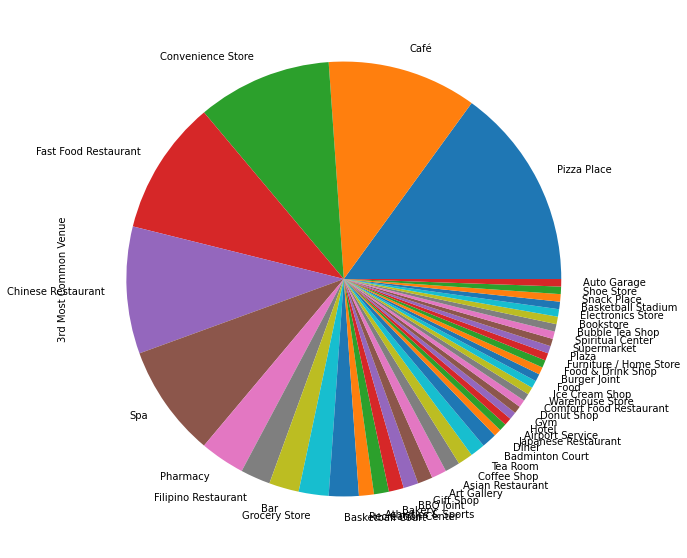

In [125]:
manila_merged.loc[manila_merged['Cluster Labels'] == 4, '3rd Most Common Venue'].value_counts().plot.pie(figsize=(10, 10))

Looking at the top 3 clusters, we can observe a trend in population vs common venues. 

The red cluster (cluster 0.0) shows a variety of restaurants as its common venues. We also have bars, bakeries and coffee shops. This cluster happen to contain barangays that are comprised of residential areas. Due to the nature of roadbuilding in Metro Manila, most of these barangays will not be travelled by a person unless he/she lives and/or visits someone in that area. 

The blue cluster (cluster 2.0) shows a spread of common venues. We can see fast food restaurants, electronics stores, gyms, pharmacies, and some niche areas like zoo exhibits. The barangays in the blue cluster happens to be areas that are frequented or commonly visited by people outside that barangay. Most of the venues there have the cheapest rates in some commodities or the area happens to house multiple commercial establishments in a common area inside the barangay.

The orange cluster (cluster 4.0) shows a larger spread of common venues compared to the blue cluster. However, one thing in common in these barangays is the frequency of convenience stores in these areas. Most of the barangays in these clusters happen to be very far to the city center to frequent the nearest mall or happen to contain transportation routes that are commonly frequented by people that wish to travel to another place.

We now proceed in plotting the COVID cases through Folium.

In [106]:
manila_merged2 = manila_merged.merge(covid.set_index('Name'), left_on='Neighborhood',right_on='Name',how='left')

In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


manila_merged2 = manila_merged2.dropna()


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, size in zip(manila_merged2['Latitude'], manila_merged2['Longitude'], manila_merged2['Neighborhood'], manila_merged2['Cluster Labels'].astype(int),manila_merged2['COVID Cases']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=size/500,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

From the plot, we can see that the barangays with higher covid cases are situated near the city center. It also happens that these barangays are also densely populated areas as well. We observe a large distribution of total covid cases in the orange cluster. There is a disparity in total covid cases in the blue cluster. For the red cluster, most of the barangays have a sharp distribution (or small deviation) in covid cases.


We now look at summary of averages below. Looking at the top three clusters (0.0/Red, 2.0/Blue, 4.0/Orange), we can see the respective covid cases and percentage affected. We can see that the red cluster has the highest percentage of infected, with orange having the second highest and blue having the third highest. Looking at the data regarding common venues in the red cluster, we can correlate how these common venues (restaurants) may have been agents of transmission for locals. 

Taking into account the quarantine measures applied during the pandemic, we should expect that transportation routes should be less frequented compared to pre-pandemic times. As the red cluster contains residential areas, we should expect high covid cases in those barangays. 

Comparing the small number of covid cases in the orange and red clusters, we can see that barangays in the orange clusters has a higher tally of cases. While transporation routes are less frequented, the transportation issue of Metro Manila may have affected transmission in these areas. 

While blue areas are commonly frequented by people from other barangays, the controlled movement of population may have contributed to the smaller covid cases of barangays in the blue cluster compared to barangays in red cluster. However, it is still important to note that the common venues in blue clusters are fast food restaurants and shopping malls. These areas may have been agents of transmission and should be recommended to be avoided as much as possible.

In [77]:
manila_merged2.groupby('Cluster Labels').mean()

,Latitude,Longitude,Population,COVID Cases,% Population
Cluster Labels,,,,,
0.0,14.596291,121.034695,29018.960159,1158.235060,4.249112
1.0,14.624226,121.018000,34915.333333,1088.666667,3.235967
2.0,14.617295,121.025340,35432.520000,1022.580000,3.984052
3.0,14.566904,121.018838,16205.142857,596.285714,4.339350
4.0,15.100398,117.837201,21260.166667,683.769231,4.105733


## Conclusion <a name="conclusion"></a>

The objective of this study is to determine a correlation between common venues in a neighborhood and the total covid cases in the neighborhood. From context and data averages, we observe a correlation in the two data. While stakeholders may now have an informed decision in further restrictions, more data may be utilized such as the rate of change of cases and travel routes of workers to complement the analysis and further fortify these claims. Nevertheless, we were able to find clusters and/or neighborhoods that may be high-risk such as barangays in Red and Blue clusters.